# Bayesian Bandits (Thompson Sampling)

Let's (for simplicity) now consider a binary problem. For example, we launch a need webpage and want to decide between version A and B. Classically, this is done by A/B-testing, where we show the pages A and B to a number of random customers and then decide which one performed better (typically measured by some binary value such as click or conversion).

This can also be done with bandits.

We assume that each of the two pages has an intrinsic conversion-rate $\theta_i$ which is unfortunately not know to us (and for simplicity not variable in time).

The goal in this Bayesian approach is to not only find some expectation value but a probability distribution of our belief what the actual value of $\theta_i$ is (based on prior knowledge/guesses and evidence).

Reminder *Bayes' theorem*:
$
P(\theta | \text{clicks}) = \frac{P(\text{clicks}| \theta) \times P(\theta)}{P(\text{clicks})}
$

In [1]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

As an example, let us assume the following probability distribution function. We can then use integration to find out with what probability the real $\theta_i$ lies between $a$ and $b$:
$
P(a < \theta_i < b) = \int_a^b f(x) \text{d}x
$

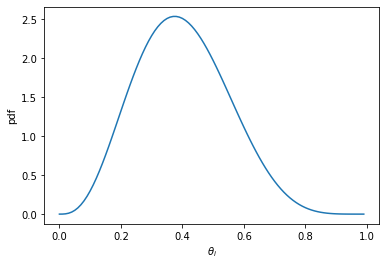

In [2]:
x = np.arange(0., 1., 0.01)
plt.plot(x, beta.pdf(x, 4, 6))
plt.xlabel("$\\theta_i$")
plt.ylabel("pdf");

## Uninformed Priors: Beta distribution

$
P(\theta_i=x) = \frac{x^{\alpha_i - 1} (1-x)^{\beta_i -1}}{B(\alpha_i, \beta_i)} \equiv f_{\alpha_i, \beta_i}(x)
$

We often use the Beta distribution as prior:
* an uninformed prior can be modeled by $f_{1,1}$
* the heuristic meaning of the parameters $\alpha$ and $\beta$ is the number of success and failure
* the Beta distribution is the conjugate prior of the Bernoulli and Binomial distribution, i.e. if the prior is a Beta distribution and the likelihood Bernoulli/Binomial, then the posterior is also a Beta distribution

Let us first look how $f_{1, 1}$ looks like (uninformed prior):

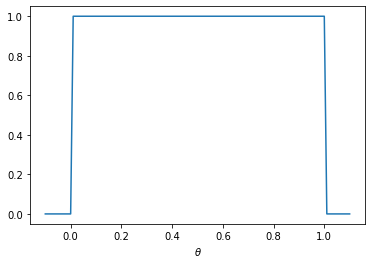

In [3]:
x = np.arange(-0.1, 1.1, 0.01)

plt.plot(x, beta.pdf(x, 1, 1))
plt.xlabel("$\\theta$");

Heuristically, the parameters are the number of successes and failures. In a case of 60 successes and 40 failures, we get this distribution, which peaks relatively narrow at $\theta=0.6$ which makes sense (in comparison to $f_{6, 5}$ which is much broader):

Text(0.5, 0, '$\\theta$')

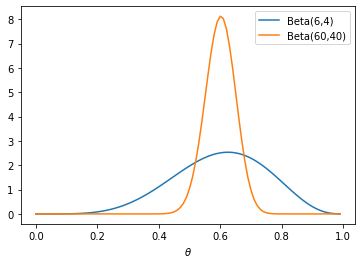

In [4]:
x = np.arange(0, 1., 0.01)

plt.plot(x, beta.pdf(x, 6, 4), label="Beta(6,4)")
plt.plot(x, beta.pdf(x, 60, 40), label="Beta(60,40)")
plt.legend()
plt.xlabel("$\\theta$")

## One Bayesian Bandit

Lets start with a Bayesian Bandit with intrinsic $\theta=0.8$ (which we know because it's synthetic data but usually would be unknown).

We have no previous knowledge, so we take an uninformed prior $f_{1, 1}$.

In [5]:
from bayesian_bandit import BayesianBandit
bandit = BayesianBandit(0.8, prior=(1., 1.))

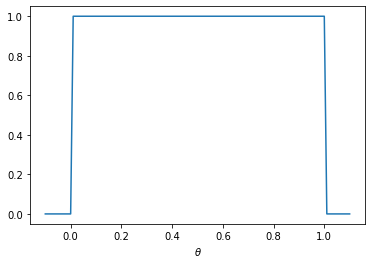

In [6]:
post = bandit.posterior()
plt.plot(post[0], post[1])
plt.xlabel("$\\theta$");

In each step, we "pull" the bandit. The result will be True or False (with a probability $\theta$).

We then "update" the bandit: As discussed above, the posterior is also a beta distribution $f_{\alpha_i + s_i, \beta_i+n_i-s_i}$ where $s_i$ is the number of successes and $n_i$ the number of tries in total (so $n_i - s_i$ is the number of failures).

We can see that the more often we pull, the narrower the distribution gets arround the underlying $\theta_i=0.8$.

In [7]:
def make_steps(n):
    success = 0
    for _ in range(n):
        R = bandit.pull()
        bandit.update(R)
        success += 1 if R else 0
    print(f"{success} times success out of {n} total")
    post = bandit.posterior()
    plt.plot(post[0], post[1])

5 times success out of 5 total


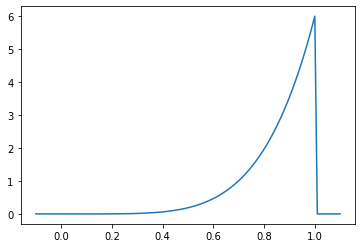

In [8]:
make_steps(5)

4 times success out of 5 total


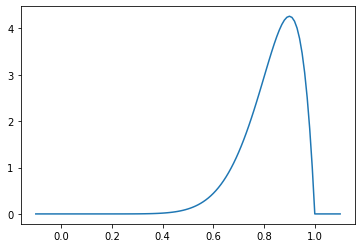

In [9]:
make_steps(5)

4 times success out of 5 total


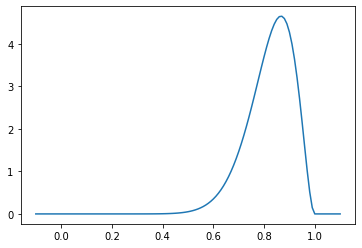

In [10]:
make_steps(5)

41 times success out of 50 total


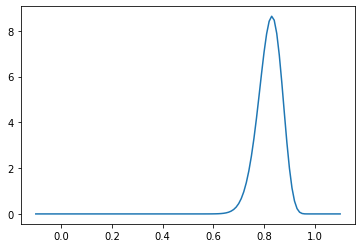

In [11]:
make_steps(50)

## Reinforcement Learning

Until now we did not make any decisions but just pulled one bandit.

Here, we have two bandits. Now the goal is not to learn the underlying $\theta_i$ but to maximize the reward.

In [12]:
bandits = [BayesianBandit(0.4), BayesianBandit(0.8)]

from collections import defaultdict
bandit_choices = defaultdict(int)

In each step, we draw samples from the posterior distributions of both bandits. We then decide which bandit to pull based on these values and update the bandit accordingly.

In the beginning, both distributions are overlapping, so we will explore both bandits but later one, we gain confidence that the second bandit is more promising.

In [13]:
def make_steps(n):
    for _ in range(n):
        chosen_bandit_no = np.argmax([bandit.sample() for bandit in bandits])
        bandit_choices[chosen_bandit_no] += 1
        chosen_bandit = bandits[chosen_bandit_no]
        R = chosen_bandit.pull()
        chosen_bandit.update(R)

    plt.figure()
    for b, bandit in enumerate(bandits):
        post = bandit.posterior()
        plt.plot(post[0], post[1], label=f"bandit {b+1}: {bandit_choices[b]}")
    plt.legend()

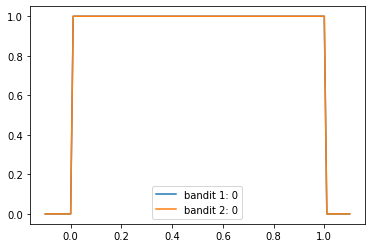

In [14]:
make_steps(0)

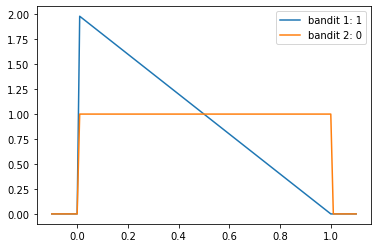

In [15]:
make_steps(1)

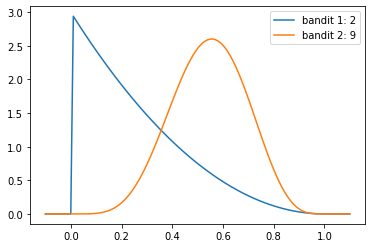

In [16]:
make_steps(10)

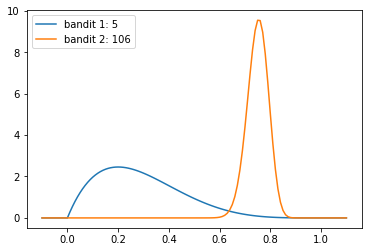

In [17]:
make_steps(100)

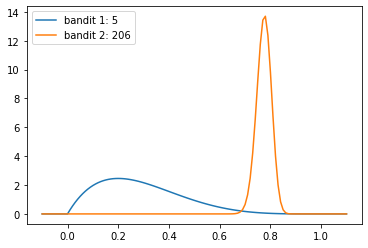

In [18]:
make_steps(100)

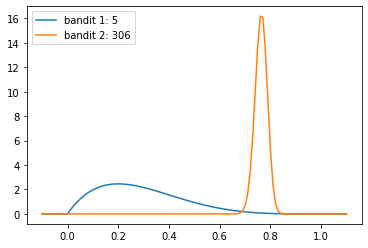

In [19]:
make_steps(100)